<a href="https://colab.research.google.com/github/SiluniKeerthiratne/DSGP/blob/vanuja/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test Model 2 (MobileNetV2)



*   Accuracy:  0.9685275554656982







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [3]:
class FruitNet:
    def __init__(self, model_config_path):
        self.model = tf.keras.models.load_model(model_config_path)

    def predict(self, img_file):
        labels = ['fresh', 'rotten']

        img_tensor = tf.image.decode_image(img_file)
        img_resized = tf.image.resize(img_tensor, [224, 224])
        img_final = tf.expand_dims(img_resized, 0)

        y_probs = self.model.predict(img_final[:,:,:,:3])
        y_label = y_probs.argmax(axis=-1)

        label = labels[y_label[0]]
        percentage = format(y_probs.max() * 100, '.2f')

        return label, percentage

In [4]:
path = "/content/drive/MyDrive/DataSet/dataset"

img_size =  (224,224,3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 3


In [5]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd


# Define paths


# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get list of directories in train_path
classes = [cls for cls in os.listdir(path) if os.path.isdir(os.path.join(path, cls))]

train_data = []
for cls in classes:
    cls_path = os.path.join(path, cls)
    imgs = [os.path.join(cls_path, img) for img in os.listdir(cls_path)]
    train_data.extend([(img, cls) for img in imgs])

train_files, test_files = train_test_split(train_data, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)


# Convert file paths and labels to DataFrame
train_df = pd.DataFrame(train_files, columns=['filename', 'class'])
val_df = pd.DataFrame(val_files, columns=['filename', 'class'])
test_df = pd.DataFrame(test_files, columns=['filename', 'class'])

# Create generators
BATCH_SIZE = 32
train_dataset = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
)

validation_dataset = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
)

test_dataset = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Assuming full paths are provided in 'filename'
    x_col='filename',
    y_col='class',
    color_mode = "rgb",
    target_size = (224,224),
    interpolation = 'bicubic',
    class_mode = "categorical",
    shuffle = True,
    batch_size = BATCH_SIZE
    )



Found 9605 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 1068 validated image filenames belonging to 2 classes.
Found 2669 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [6]:
LABELS = ['fresh', 'rotten']

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
base_model.trainable = False

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(32, 7, 7, 1280)


In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [17]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 [==============================] - 348s 10s/step - loss: 0.7898 - accuracy: 0.5627


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.56


In [19]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/3
301/301 [==============================] - 1565s 5s/step - loss: 0.2017 - accuracy: 0.9205 - val_loss: 0.0992 - val_accuracy: 0.9691
Epoch 2/3
301/301 [==============================] - 635s 2s/step - loss: 0.1175 - accuracy: 0.9586 - val_loss: 0.0822 - val_accuracy: 0.9747
Epoch 3/3
301/301 [==============================] - 622s 2s/step - loss: 0.0987 - accuracy: 0.9648 - val_loss: 0.0636 - val_accuracy: 0.9831


In [20]:
score = model.evaluate(test_dataset)
print("Accuracy: ",score[1])

84/84 [==============================] - 417s 5s/step - loss: 0.0900 - accuracy: 0.9685
Accuracy:  0.9685275554656982


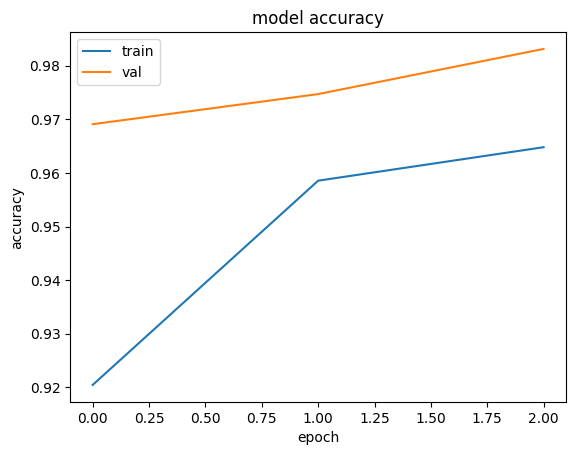

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

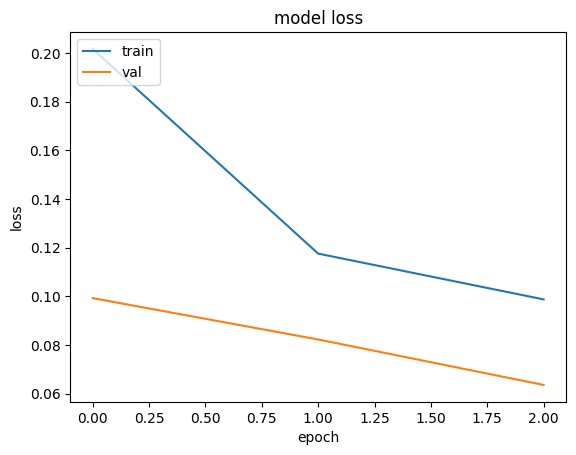

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import classification_report
test_labels = test_dataset.classes
predictions = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_dataset.class_indices))

84/84 [==============================] - 154s 2s/step
              precision    recall  f1-score   support

       Fresh       0.43      0.43      0.43      1179
      Rotten       0.55      0.55      0.55      1490

    accuracy                           0.49      2669
   macro avg       0.49      0.49      0.49      2669
weighted avg       0.49      0.49      0.49      2669



In [24]:
from PIL import Image

img_path='/content/drive/MyDrive/DataSet/rotten.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)

1/1 [==============================] - 1s 923ms/step


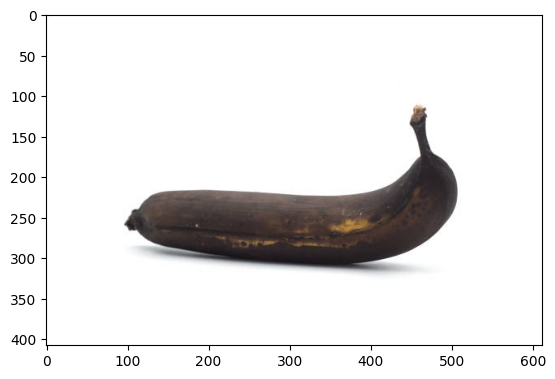

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/DataSet/rotten.jpg")
plt.imshow(img)
plt.show()

In [26]:
prediction

array([[0.69771594, 0.30228403]], dtype=float32)

1/1 [==============================] - 0s 49ms/step


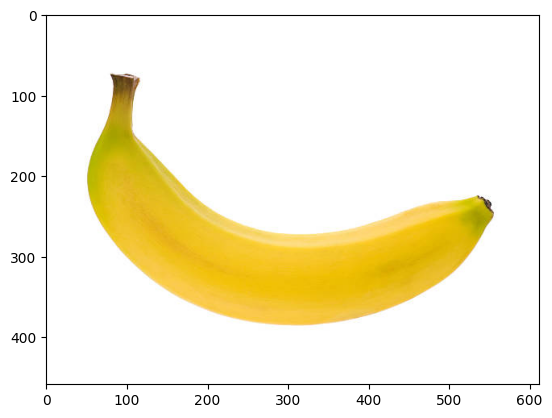

In [47]:
img_path='/content/drive/MyDrive/DataSet/fresh.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)
img = mpimg.imread("/content/drive/MyDrive/DataSet/fresh.jpg")
plt.imshow(img)
plt.show()

In [30]:
prediction

array([[0.67118573, 0.32881427]], dtype=float32)

In [50]:
img_path = '/content/drive/MyDrive/DataSet/rotten3.png'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

prediction = model.predict(img_preprocessed)

1/1 [==============================] - 0s 47ms/step


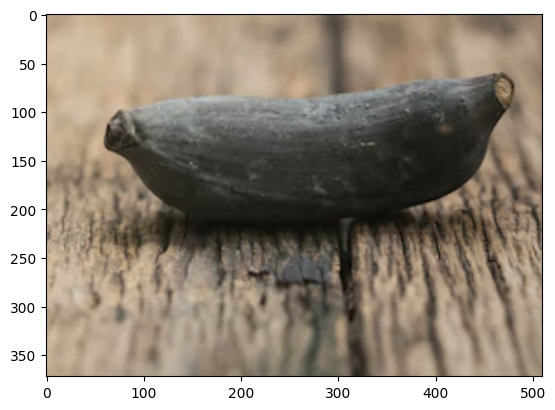

In [51]:
img = mpimg.imread("/content/drive/MyDrive/DataSet/rotten3.png")
plt.imshow(img)
plt.show()

In [52]:
predicted_class_index = np.argmax(prediction)
predicted_class = LABELS[predicted_class_index]
predicted_probability = prediction[0][predicted_class_index]

print("Predicted Class:", predicted_class)
print("Probability:", predicted_probability)

Predicted Class: fresh
Probability: 0.5164125
